# Yankees - Event Propensity - Next Event Buyer
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Feb 09, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··························


In [4]:
cursor = CNXN.cursor()

query = "SELECT * FROM datascience.yankees.event_propensity_training_noFirstPurchases2"
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [5]:
df.to_parquet('yankees-data-export-event.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266386 entries, 0 to 266385
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysOut              266386 non-null  object        
 1   minDaysOut           266386 non-null  int64         
 2   maxDaysOut           147819 non-null  float64       
 3   dimCustomerMasterId  266386 non-null  int64         
 4   recent_openRate      266386 non-null  float64       
 5   recent_clickRate     266386 non-null  float64       
 6   eventDate            266386 non-null  datetime64[ns]
 7   eventName            266386 non-null  object        
 8   inMarket             242800 non-null  object        
 9   distanceToVenue      242800 non-null  float64       
 10  tenure               266386 non-null  int64         
 11  did_purchase         266386 non-null  int64         
 12  events_purchased     266386 non-null  int64         
 13  frequency_oppo

### We should create separate training and evaluation datasets:

In [5]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (226428, 16)
Unseen Data For Predictions: (39958, 16)



### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [6]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=["dimCustomerMasterId","eventName","minDaysOut","maxDaysOut"],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate"
    ]
);

In [ ]:
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold= 10, 
    include= [ngboost]
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8247,0.9034,0.8348,0.8184,0.8265,0.6493,0.6495
1,0.8230,0.9025,0.8318,0.8176,0.8247,0.6460,0.6461
2,0.8216,0.9014,0.8245,0.8199,0.8222,0.6433,0.6433
3,0.8257,0.9033,0.8284,0.8241,0.8263,0.6514,0.6514
4,0.8221,0.9019,0.8291,0.8179,0.8234,0.6443,0.6443
5,0.8228,0.9001,0.8294,0.8188,0.8241,0.6457,0.6457
6,0.8248,0.9017,0.8319,0.8204,0.8261,0.6497,0.6497
7,0.8228,0.9022,0.8234,0.8226,0.8230,0.6457,0.6457
8,0.8193,0.9004,0.8237,0.8166,0.8201,0.6385,0.6385
9,0.8220,0.9021,0.8279,0.8185,0.8231,0.6440,0.6441


IntProgress(value=0, description='Processing: ', max=9)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:37:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,NGBClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.4414 val_loss=0.0000 scale=2.0000 norm=3.3892
[iter 200] loss=0.4111 val_loss=0.0000 scale=1.0000 norm=1.7637
[iter 300] loss=0.4031 val_loss=0.0000 scale=1.0000 norm=1.8150
[iter 400] loss=0.3971 val_loss=0.0000 scale=1.0000 norm=1.8512
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.4418 val_loss=0.0000 scale=2.0000 norm=3.3900
[iter 200] loss=0.4114 val_loss=0.0000 scale=1.0000 norm=1.7658
[iter 300] loss=0.4035 val_loss=0.0000 scale=1.0000 norm=1.8179
[iter 400] loss=0.3981 val_loss=0.0000 scale=1.0000 norm=1.8531


### The top model is performing well, so let's compare it against our test dataset:

In [165]:
best_model = create_model(
    model_matrix, 
    fold= 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8494,0.9240,0.8409,0.8560,0.8484,0.6988,0.6989
1,0.8446,0.9221,0.8362,0.8511,0.8436,0.6892,0.6893
2,0.8411,0.9187,0.8277,0.8510,0.8392,0.6821,0.6824
3,0.8408,0.9194,0.8299,0.8489,0.8393,0.6816,0.6818
4,0.8410,0.9196,0.8309,0.8485,0.8396,0.6819,0.6821
5,0.8458,0.9215,0.8327,0.8557,0.8440,0.6916,0.6919
6,0.8484,0.9240,0.8424,0.8532,0.8478,0.6968,0.6969
7,0.8427,0.9228,0.8397,0.8453,0.8425,0.6853,0.6853
8,0.8411,0.9210,0.8320,0.8480,0.8399,0.6821,0.6823
9,0.8478,0.9232,0.8325,0.8593,0.8457,0.6956,0.6960


### Let's load in our evaluation data and get propensity scores using the model:

In [166]:
df_inference = predict_model(best_model, data=df_eval, raw_score=True)
df_inference.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,Label,Score_0,Score_1
3,1 to 3 Days Out,1,4.0,1488,0.00,0.0,2019-08-03,20190803 - Boston Red Sox,True,50.53,122,0,52,0.000000,0.000000,0.000000,0,0.7848,0.2152
8,1 to 3 Days Out,1,4.0,1980,0.25,0.0,2017-09-30,20170930 - Toronto Blue Jays,True,85.07,177,1,77,0.285714,0.545455,0.428571,1,0.0102,0.9898
13,1 to 3 Days Out,1,4.0,3071,0.00,0.0,2021-05-05,20210505 - Houston Astros,True,31.05,1387,0,219,0.000000,0.000000,0.000000,0,0.9503,0.0497
29,1 to 3 Days Out,1,4.0,8115,0.00,0.0,2018-05-09,20180509 - Boston Red Sox,True,23.24,350,1,78,0.181818,0.000000,0.113636,1,0.1298,0.8702
37,1 to 3 Days Out,1,4.0,10753,0.00,0.0,2017-06-08,20170608 - Boston Red Sox,True,25.47,106,0,26,0.000000,0.000000,0.000000,0,0.7452,0.2548


### Included are some metrics on did and did_not purchase:

In [167]:
did_purchase = df_inference["Label"].value_counts()[1]
did_not_purchase = df_inference["Label"].value_counts()[0]
total_rows = df_inference["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 2) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 19555
Would not purchase: 20403
Purchase percentage: 49.0


### We can also see the correlation between the features and the target variable:

In [168]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime
minDaysOut,1.00,0.98,0.10,-0.10,-0.05,-0.09,-0.03,0.36,0.02,-0.05,0.02,-0.06
maxDaysOut,0.98,1.00,0.01,-0.05,-0.01,0.01,0.07,-0.03,0.06,-0.15,-0.10,-0.16
dimCustomerMasterId,0.10,0.01,1.00,0.10,0.04,-0.14,0.06,0.39,0.07,0.13,0.13,0.12
recent_openRate,-0.10,-0.05,0.10,1.00,0.14,-0.03,-0.02,0.08,-0.03,0.09,0.06,0.10
recent_clickRate,-0.05,-0.01,0.04,0.14,1.00,-0.03,-0.03,0.07,-0.03,0.04,0.04,0.04
distanceToVenue,-0.09,0.01,-0.14,-0.03,-0.03,1.00,0.02,-0.24,-0.00,-0.06,-0.08,-0.09
tenure,-0.03,0.07,0.06,-0.02,-0.03,0.02,1.00,-0.13,0.95,-0.13,-0.18,-0.23
did_purchase,0.36,-0.03,0.39,0.08,0.07,-0.24,-0.13,1.00,-0.05,0.27,0.29,0.29
events_purchased,0.02,0.06,0.07,-0.03,-0.03,-0.00,0.95,-0.05,1.00,-0.12,-0.16,-0.22
frequency_opponent,-0.05,-0.15,0.13,0.09,0.04,-0.06,-0.13,0.27,-0.12,1.00,0.44,0.59


### Here we can see the distribution of fans who did and did not purchase : Score_0 = Did Not Purchase, Score_1 = Did Purchase

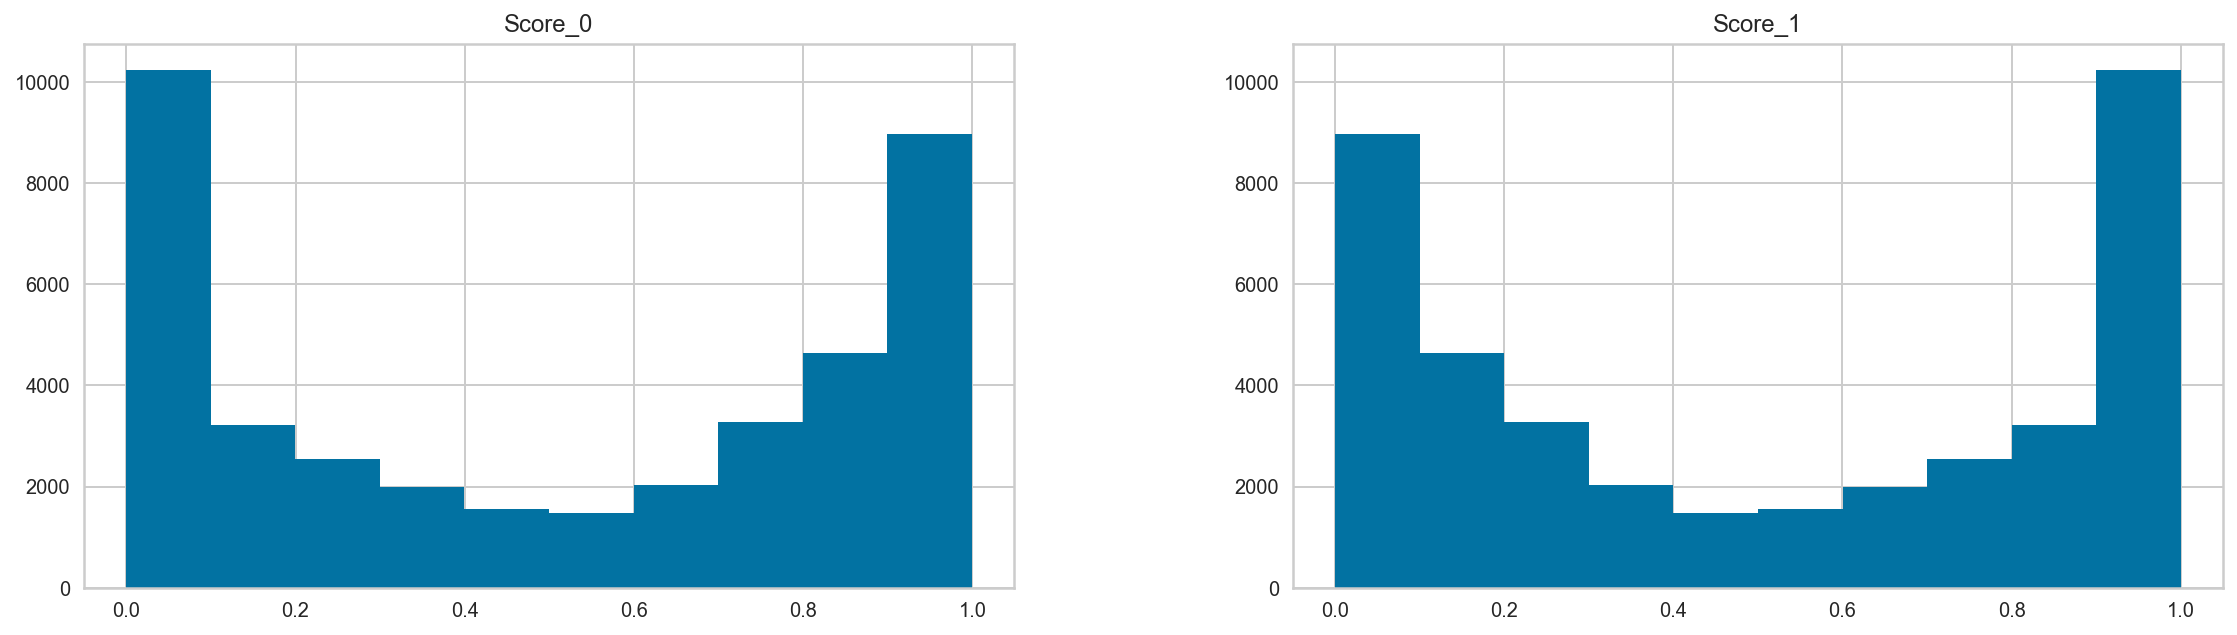

In [169]:
df_inference.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

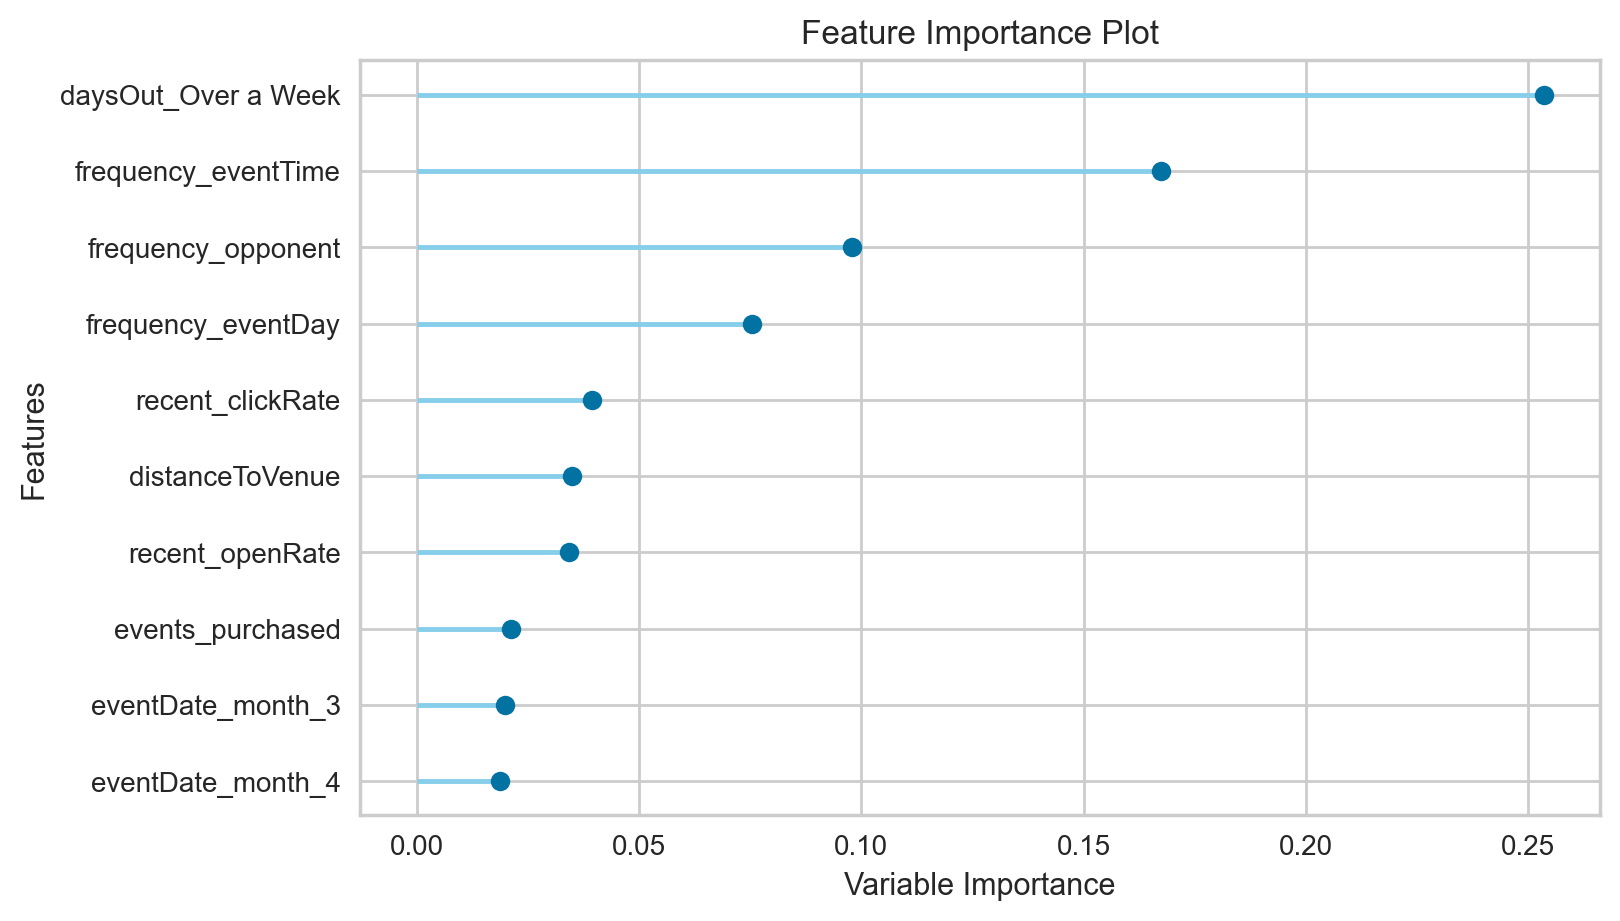

In [170]:
plot_model(best_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

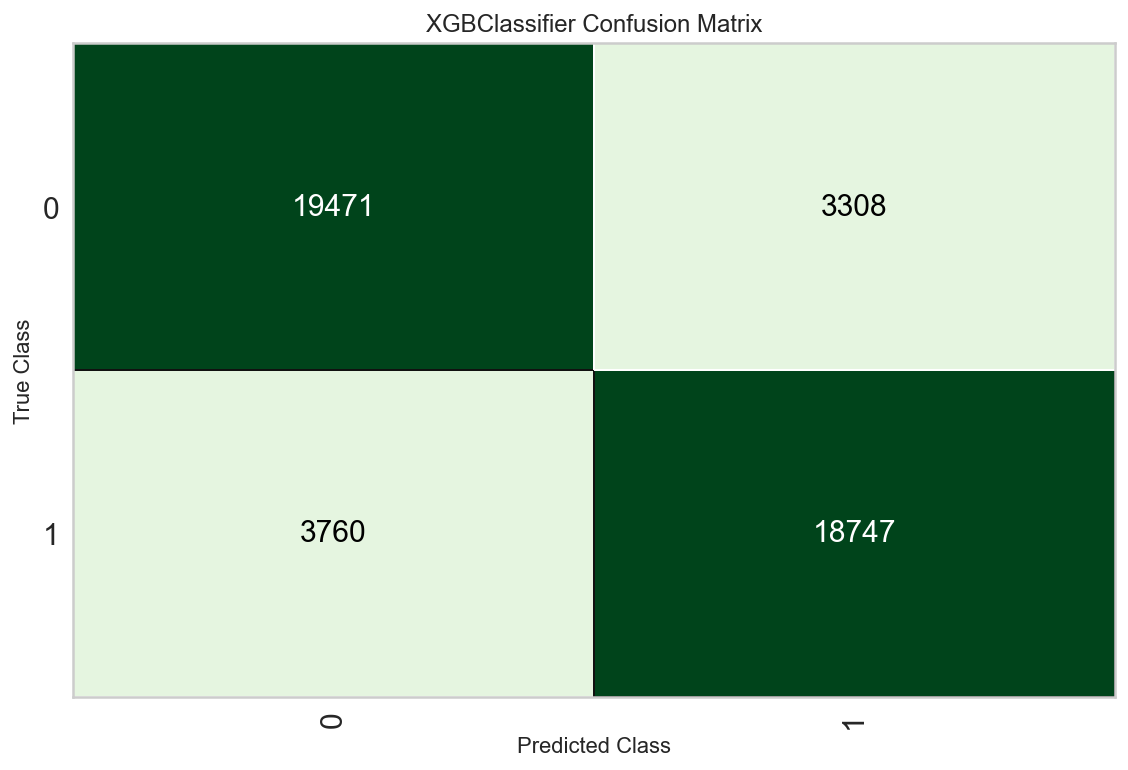

In [171]:
plot_model(best_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

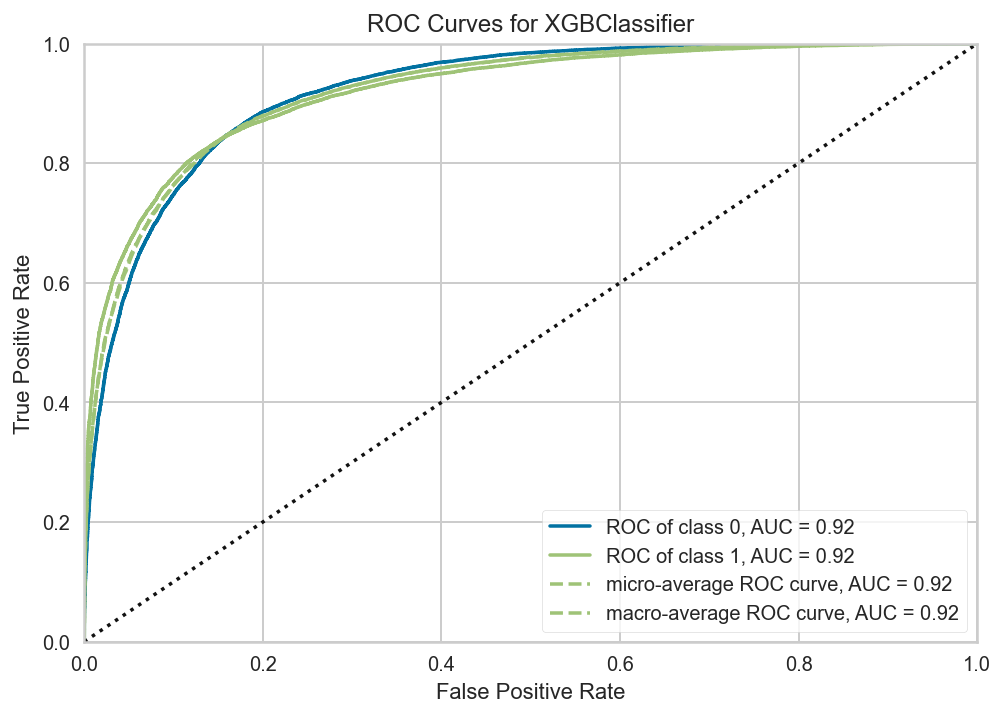

In [172]:
plot_model(best_model, plot='auc')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?